# Fermi AI/ML Usage Statistics
This notebook polls the SAO/NASA Astrophysics Data System [(ADS)](https://ui.adsabs.harvard.edu/) to determine usage rates of AI/Machine Learning with Fermi data/results.

## Setting up the API
In the fields below, `token` should be replaced with [your own API token](https://ui.adsabs.harvard.edu/user/settings/token). If you haven't worked with the ADS API before, it's recommended that you read the [README](https://github.com/adsabs/adsabs-dev-api/blob/master/README.md) before beginning. You may want to familiarize yourself with their other API Jupyter notebooks, especially the ones on [searching](https://github.com/adsabs/adsabs-dev-api/blob/master/Search_API.ipynb), [interacting with libraries](https://github.com/adsabs/adsabs-dev-api/blob/master/Libraries_API.ipynb), and [using the API with Python](https://github.com/adsabs/adsabs-dev-api/blob/master/Converting_curl_to_python.ipynb).

Note that much of the code in this notebook was adapted from the example notebook for [maintaining a mission bibliography](https://github.com/adsabs/adsabs-dev-api/blob/master/API_documentation_Python/API_examples/maintain_mission_bibliography.ipynb) on the ADS website.

In [1]:
# import the requests package and set your token in a variable for later use
import os
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

token="i4bKvOj8azhzoZp1wi1eSV3B9BTuJQUhSo7qboHp"
base_url = "https://api.adsabs.harvard.edu/v1/search/query?"

The usage statistics are compiled in *very* simple fashion: count the number of refereed publications that reference 'Fermipy' in a given year vs. the number of publications that only reference the FermiTools (formerly ScienceTools). This will give us a rough lower bound for Fermipy usage amongst the community. If you were to enter the queries into the ADS online search, they would look like this:

query = abstract:"Artificial intelligence" OR abstract:"machine learning" OR abstract:"large language model" OR abstract:"pytorch" OR abstract:"tensorflow" OR abstract:"llama" OR abstract:"ollama" OR abstract:"mistral" OR abstract:"scikitlearn" OR abstract:"keras" OR abstract:"Sagemaker" OR abstract:"Hugging Face" OR abstract:"MXNet" OR abstract:"Gluon", abstract:"Fermi", abstract:"gamma",  year:2024, property:refereed

After you enter your query into the ADS search bar, you'll notice that the url changes to reflect the specfic paramters of your search. You'll want to copy everything after the "search/q=" part of these urls for use in the next step:

query = '%7B!type%3Daqp%20v%3D%24fq_database%7D&fq_database=(database%3Aastronomy%20OR%20database%3Aphysics)&q=abstract%3A"Artificial%20intelligence"%20OR
%20abstract%3A"machine%20learning"%20OR%20abstract%3A"large%20language%20model"%20OR
%20abstract%3A"pytorch"%20OR%20abstract%3A"tensorflow"%20OR%20abstract%3A"llama"%20OR%20abstract%3A"ollama"%20OR
%20abstract%3A"mistral"%20OR%20abstract%3A"scikitlearn"%20OR%20abstract%3A"keras"%20OR%20abstract%3A"Sagemaker"%20OR
%20abstract%3A"Hugging%20Face"%20OR%20abstract%3A"MXNet"%20OR%20abstract%3A"Gluon"%2C
%20abstract%3A"Fermi"%2C%20abstract%3A"gamma"%2C%20%20year%3A2024%2C%20property%3Arefereed&sort=date%20desc%2C%20bibcode%20desc&p_=0'

In [2]:
# Remove false positives (papers that are not actually Fermi-related AI/ML studies)
badBibs = ['2009EPJB...72..575M','2009JPSJ...78h4711D','2010PhyC..470S.758U','2011PhyB..406.4678W','2011PhRvL.107z7601D','2011PSSBR.248.2269P',
          '2011JETPL..93..166N','2012PhRvD..86h3521C','2012JMMM..324.3481S','2013JMMM..345..294R','2013JMMM..342...80R','2014NIMPA.763..442A',
          '2014JMMM..358...16R','2014JMMM..352...72R','2014JMMM..351...98R','2015OptMa..47..453R','2015PhRvD..91g2002A','2016JHEP...09..077L',
          '2016PhRvD..93k5006H','2016NPPP..273.2118L','2017JETPL.105..370N','2017PhDT.......245C','2018JETPL.108..623N','2018JCAP...07..008B',
          '2018AN....339..352R','2018JETP..126..485N','2018MNRAS.475..306R','2018JPCM...30h5601H','2019PhRvB.100m4436W','2020A&A...638A.128M',
          '2020PhRvE.101e3203M','2020PhyS...95d5813A','2020ChPhB..29d7101M','2021AppRI.16909583O','2021Entrp..23..223T','2021PhRvC.103a4305B',
          '2021PhRvC.103a4305B','2022PhRvD.106j3526B','2022FrP....10.4439L','2022PSSBR.25900151K','2022ApJ...926..170Z','2023PhRvD.108l3035Z',
          '2023JPCS..18111547L','2023PhRvD.107f3032Z','2023ChPhB..32e7306M']

In [69]:
startYear = 2008
endYear = 2025

year = []
aict = {} # array to store count of Fermi-AI papers
pubs = []
biblist = []
for year in range(startYear,endYear): 
    # This block gets the Fermi papers that use ML/AI
    results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?" \
                           '%7B!type%3Daqp%20v%3D%24fq_database%7D' \
                           '&fq_database=(database%3Aastronomy%20OR%20database%3Aphysics)&p_=0' \
                           '&q=%3Dabstract%3A%22Artificial%20intelligence%22%20OR%20%3Dabstract%3A%22machine%20learning%22%20OR' \
                           '%20abstract%3A%22neural%20network%22%20OR%20abstract%3A%22neural%20networks%22%20OR%20abstract%3A%22CNN%22%20OR' \
                           '%20abstract%3A%22decision%20tree%22%20OR%20abstract%3A%22decision%20forest%22%20OR%20abstract%3A%22random%20forest%22%20OR' \
                           '%20abstract%3A%22tensorflow%22%20OR%20abstract%3A%22llama%22%20OR%20abstract%3A%22ollama%22%20OR' \
                           '%20abstract%3A%22mistral%22%20OR%20abstract%3A%22scikitlearn%22%20OR%20abstract%3A%22keras%22%20OR' \
                           '%20abstract%3A%22Sagemaker%22%20OR%20abstract%3A%22Hugging%20Face%22%20OR%20abstract%3A%22MXNet%22%20OR' \
                           '%20abstract%3A%22Hugging%20Face%22%20OR%20abstract%3A%22MXNet%22%20OR%20abstract%3A%22Gluon%22%2C' \
                           '%20abstract%3A%22Fermi%22%2C%20abstract%3A%22gamma%22%2C%20year%3A'+str(year+1)+'%2C%20property%3Arefereed' \
                           "&sort=date%20desc%2C%20bibcode%20desc" \
                           "&fl=bibcode,title,author,year" \
                           "&rows=500", \
                           headers={'Authorization': 'Bearer ' + token})
    res = results.json()['response']['docs']
    cleanRes = []
    for h in res:
        if any(bib for bib in badBibs if(bib in h.values())) is False:
            cleanRes.append(h)
    pubs.append(cleanRes)
    bibcodes = [d['bibcode'] for d in cleanRes]
    for code in bibcodes:
        biblist.append(code)
    aict[year+1]=len(bibcodes)
    print("\nFermi AI papers in "+str(year+1)+": "+str(len(bibcodes)))
    for i in cleanRes:
        print(i['bibcode']+'\n','  '+i['title'][0]+'\n','  '+i['author'][0]+' & '+str(len(i['author'])-1)+' co-authors')
    year+=1
print(aict)
print("Total number of papers:",str(sum(aict.values())))


Fermi AI papers in 2009: 0

Fermi AI papers in 2010: 0

Fermi AI papers in 2011: 0

Fermi AI papers in 2012: 1
2012MNRAS.424L..64M
   Fermi's SIBYL: mining the gamma-ray sky for dark matter subhaloes
   Mirabal, N. & 3 co-authors

Fermi AI papers in 2013: 2
2013ApJ...776L..34S
   Discovery and Redshift of an Optical Afterglow in 71 deg<SUP>2</SUP>: iPTF13bxl and GRB 130702A
   Singer, Leo P. & 22 co-authors
2013MNRAS.428..220H
   Gamma-ray active galactic nucleus type through machine-learning algorithms
   Hassan, T. & 3 co-authors

Fermi AI papers in 2014: 1
2014ApJ...782...41D
   Search for Gamma-ray-emitting Active Galactic Nuclei in the Fermi-LAT Unassociated Sample Using Machine Learning
   Doert, M. & 1 co-authors

Fermi AI papers in 2015: 1
2015MNRAS.454.1132T
   Distinguishing short and long Fermi gamma-ray bursts
   Tarnopolski, M. & 0 co-authors

Fermi AI papers in 2016: 4
2016MNRAS.462.3180C
   Blazar flaring patterns (B-FlaP) classifying blazar candidate of uncertain type 

In [70]:
# Sadly, no search algorithm is perfect. Identify papers that should have been included & add their bibcodes here
extraPubs = ['2020A&C....3200387X','2021JCAP...11..033M','2012ApJ...753...83A']
for pub in extraPubs:
    if pub not in biblist:
        print('Adding '+pub+' to the bibliography')
        yr = int(pub[:4])
        aict[yr] += 1
        biblist.append(pub)
    else:
        print('Article '+pub+' was already included. Skipping this publication...')
print(aict)
print("Total number of papers:",str(sum(aict.values())))

Adding 2020A&C....3200387X to the bibliography
Adding 2021JCAP...11..033M to the bibliography
Adding 2012ApJ...753...83A to the bibliography
{2009: 0, 2010: 0, 2011: 0, 2012: 2, 2013: 2, 2014: 1, 2015: 1, 2016: 4, 2017: 2, 2018: 3, 2019: 9, 2020: 7, 2021: 16, 2022: 9, 2023: 16, 2024: 13, 2025: 0}
Total number of papers: 85


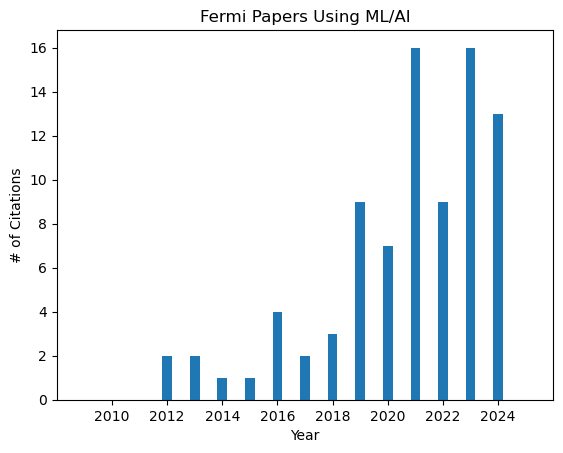

In [71]:
width = 0.35
p1 = plt.bar(*zip(*aict.items()), width)

plt.title('Fermi Papers Using ML/AI')
plt.ylabel('# of Citations')
plt.xlabel('Year')

plt.show()

In [72]:
# How many total ML/AI Fermi papers were published in the selected period?
print("Total number of papers:",str(sum(aict.values())))

Total number of papers: 85


## Make a Library

In [7]:
# create a dictionary with the payload values
# Only need to do this once
payload = {'name': 'Fermi AI/ML',
           'description': 'Fermi papers that leverage AI/ML methods',
           'public': True,
           'bibcode': biblist}

# the json library offers an easy way to convert between JSON or dictionaries and their serialized strings

serialized_payload = json.dumps(payload)

library_response = requests.post('https://api.adsabs.harvard.edu/v1/biblib/libraries', \
                                 headers={'Authorization': 'Bearer ' + token},
                                 data=serialized_payload)

library_response.json()
id = library_response.json()['id']

KeyError: 'id'

In [ ]:
# Update the library with new papers as this notebook is re-run in the future.
# CHANGE THE ID if you are creating a new notebook!!
try:
    id
except NameError:
    id = 'KHlaDIZxT5emziwHrgbLNA'
print("Library ID: "+id)
payload = {'bibcode': biblist,
           'action': 'add'}

serialized_payload = json.dumps(payload)

library_edit_response = requests.post('https://api.adsabs.harvard.edu/v1/biblib/documents/{}'.format(id), \
                                      headers={'Authorization': 'Bearer ' + token},
                                      data=serialized_payload)

library_edit_response, library_edit_response.json()